# FAIR run for Methane

In [1]:
import sys  
sys.path.append("..")
from fair.SSPs import ssp245,ssp585
from fair import *
from plot_fair import *

import country_converter as coco


import matplotlib as mpl
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

%matplotlib inline

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['font.size'] =30
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['legend.fontsize'] = 20 
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.major.pad']='8'
mpl.rcParams['ytick.major.pad']='8'

### 1. Concentration based run
We first need to find emissions that ensure a constant atmospheric $CH_4$ concentration after the year of the pulse.

In [2]:
conc_in = return_empty_emissions(df_to_copy=False, start_year=1765, end_year=3100, timestep=1, scen_names=['yr_'+str(i) for i in range(1850,2020)], gases_in = ['methane'])

for label in ['yr_'+str(i) for i in range(1850,2020)]:
    t = int(label.split('yr_')[-1])
   
    conc_in.loc[:t,(label,'methane')]=ssp245.Concentrations.ch4[ssp245.Concentrations.year<=t]
    conc_in.loc[t:,(label,'methane')]=ssp245.Concentrations.ch4[ssp245.Concentrations.year==t][0]
    
test_gas = get_gas_parameter_defaults().reindex(conc_in.columns.levels[1],axis=1,level=1)

In [3]:
conc_out = run_FaIR(concentrations_in=conc_in,forcing_in=return_empty_forcing(conc_in),gas_parameters=test_gas,thermal_parameters=get_thermal_parameter_defaults())

Integrating 170 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['methane'] forcing agents, between 1765 and 3100...


100%|██████████| 1335/1335 [00:00<00:00, 1921.51 timestep/s]


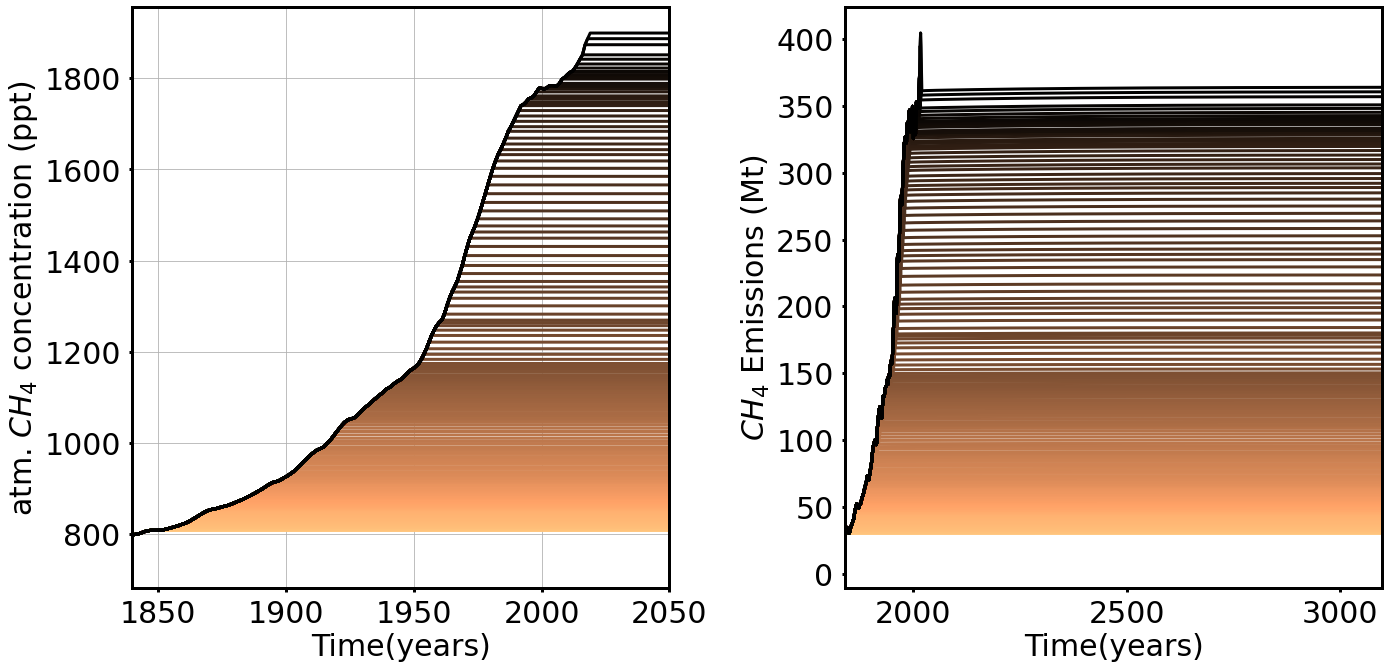

In [4]:
fig=plt.figure(1,figsize=(20,10))
ax1=plt.subplot(121)
conc_out['C'].plot(legend=False,cmap='copper_r',ax=ax1)
ax1.set_ylabel(r'atm. $CH_4$ concentration (ppt)')
ax1.set_xlabel('Time(years)')
ax1.set_xlim(1840,2050)
ax1.grid()
ax2=plt.subplot(122)
ax2.set_xlim(1840,3100)
conc_out['Emissions'].plot(legend=False,cmap='copper_r',ax=ax2)
ax2.set_ylabel(r'$CH_4$ Emissions (Mt)')
ax2.set_xlabel('Time(years)')
fig.tight_layout();

Convert emission output from the concentration based run to an input DataFrame (delete the Gas cycle row and rename to Gas):

In [5]:
control_in = conc_out['Emissions'].droplevel(1,axis=1)
control_in.columns = control_in.columns.rename("Gas", level=1)

### 2. Control run

In [6]:
control_out = run_FaIR(emissions_in=control_in,forcing_in=return_empty_forcing(control_in),gas_parameters=test_gas,thermal_parameters=get_thermal_parameter_defaults())

Integrating 170 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['methane'] forcing agents, between 1765 and 3100...


100%|██████████| 1335/1335 [00:00<00:00, 2273.97 timestep/s]


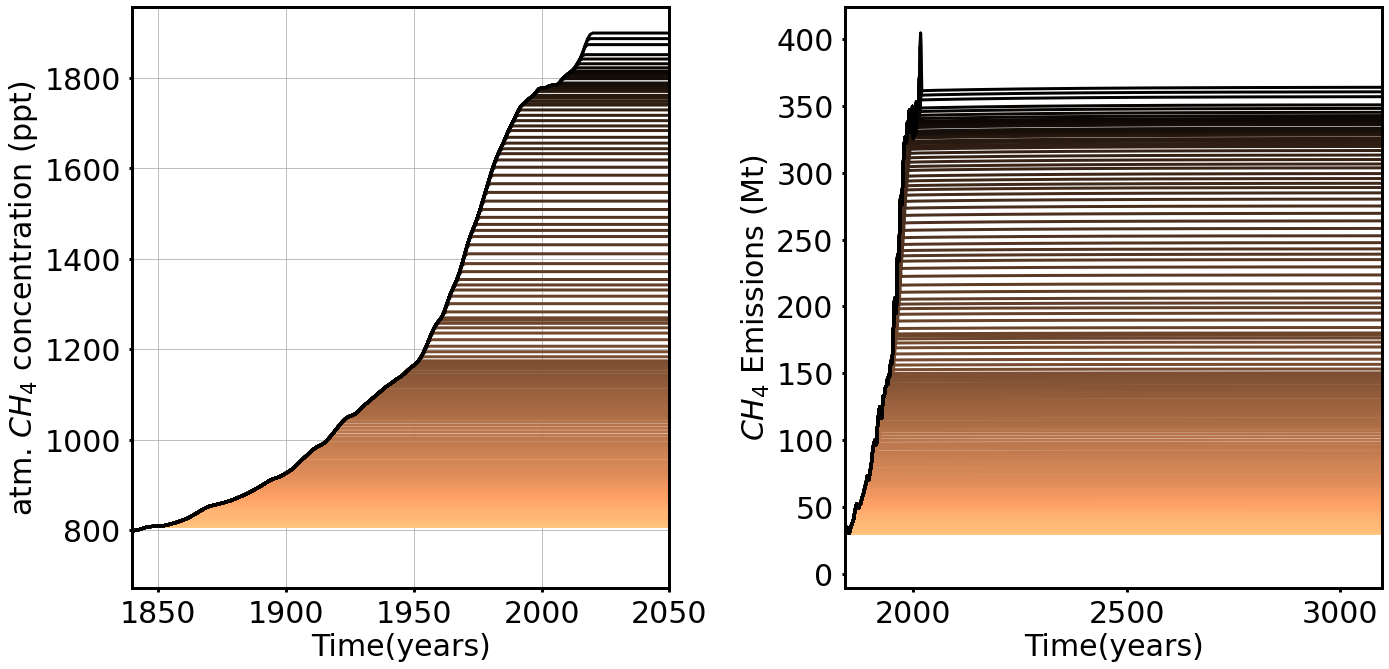

In [7]:
fig=plt.figure(1,figsize=(20,10))
ax1=plt.subplot(121)
control_out['C'].plot(legend=False,cmap='copper_r',ax=ax1)
ax1.set_ylabel(r'atm. $CH_4$ concentration (ppt)')
ax1.set_xlabel('Time(years)')
ax1.set_xlim(1840,2050)
ax1.grid()
ax2=plt.subplot(122)
ax2.set_xlim(1840,3100)
control_out['Emissions'].plot(legend=False,cmap='copper_r',ax=ax2)
ax2.set_ylabel(r'$CH_4$ Emissions (Mt)')
ax2.set_xlabel('Time(years)')
fig.tight_layout();

### 3. Get Methane data & Pulse run

In [8]:
primap = pd.read_csv('../data/PRIMAP/Guetschow-et-al-2021-PRIMAP-hist_v2.3.1_20-Sep_2021.csv')

primap = primap.rename(columns={"category (IPCC2006_PRIMAP)": "category",
                                "area (ISO3)":"ISO3",
                                "scenario (PRIMAP-hist)":"scenario"})

#select the HISTCR scenario (country-reported data is prioritized over third-party data)
primap = primap[primap.scenario=='HISTCR']

# select National Total excluding LULUCF
primap = primap[primap.category=='M.0.EL']

ch4 = primap[primap.entity=='CH4'].set_index('ISO3')
ch4= ch4.loc[:,[str(t) for t in range(1750,2020)]]
ch4.columns = ch4.columns.astype('int')
# convert Gg to Mt
ch4 = ch4/1000
ch4.to_csv('../data/PRIMAP/primap_CH4.csv')

In [9]:
import copy
pulse_in = copy.deepcopy(control_in)
for t in range(1850,2016):
    pulse_in.loc[t,'yr_'+str(t)].methane = pulse_in.loc[t,'yr_'+str(t)].methane + ch4.loc['EARTH',t]

In [10]:
pulse_out = run_FaIR(emissions_in=pulse_in,forcing_in=return_empty_forcing(pulse_in),gas_parameters=test_gas,thermal_parameters=get_thermal_parameter_defaults())

Integrating 170 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['methane'] forcing agents, between 1765 and 3100...


100%|██████████| 1335/1335 [00:00<00:00, 2150.46 timestep/s]


### 4. Results

In [11]:
# create colormaps for concentration plot
conc_cmap = create_color_maps(170, ppm_color='conc')
# create colormaps for GMT change plot
T_cmap = create_color_maps(170)

[['546A7B', 5], ['62929E', 10], ['C6C5B9', 2]]
[['9E2A2B', 5], ['BF6535', 10], ['E09F3E', 2]]


In [12]:
ch4_diff = (pulse_out['C']-control_out['C']).droplevel(1,axis=1).droplevel(1,axis=1)
# cut all values smaller than zero to zero (because of error propagation)
ch4_diff[ch4_diff <0]=0

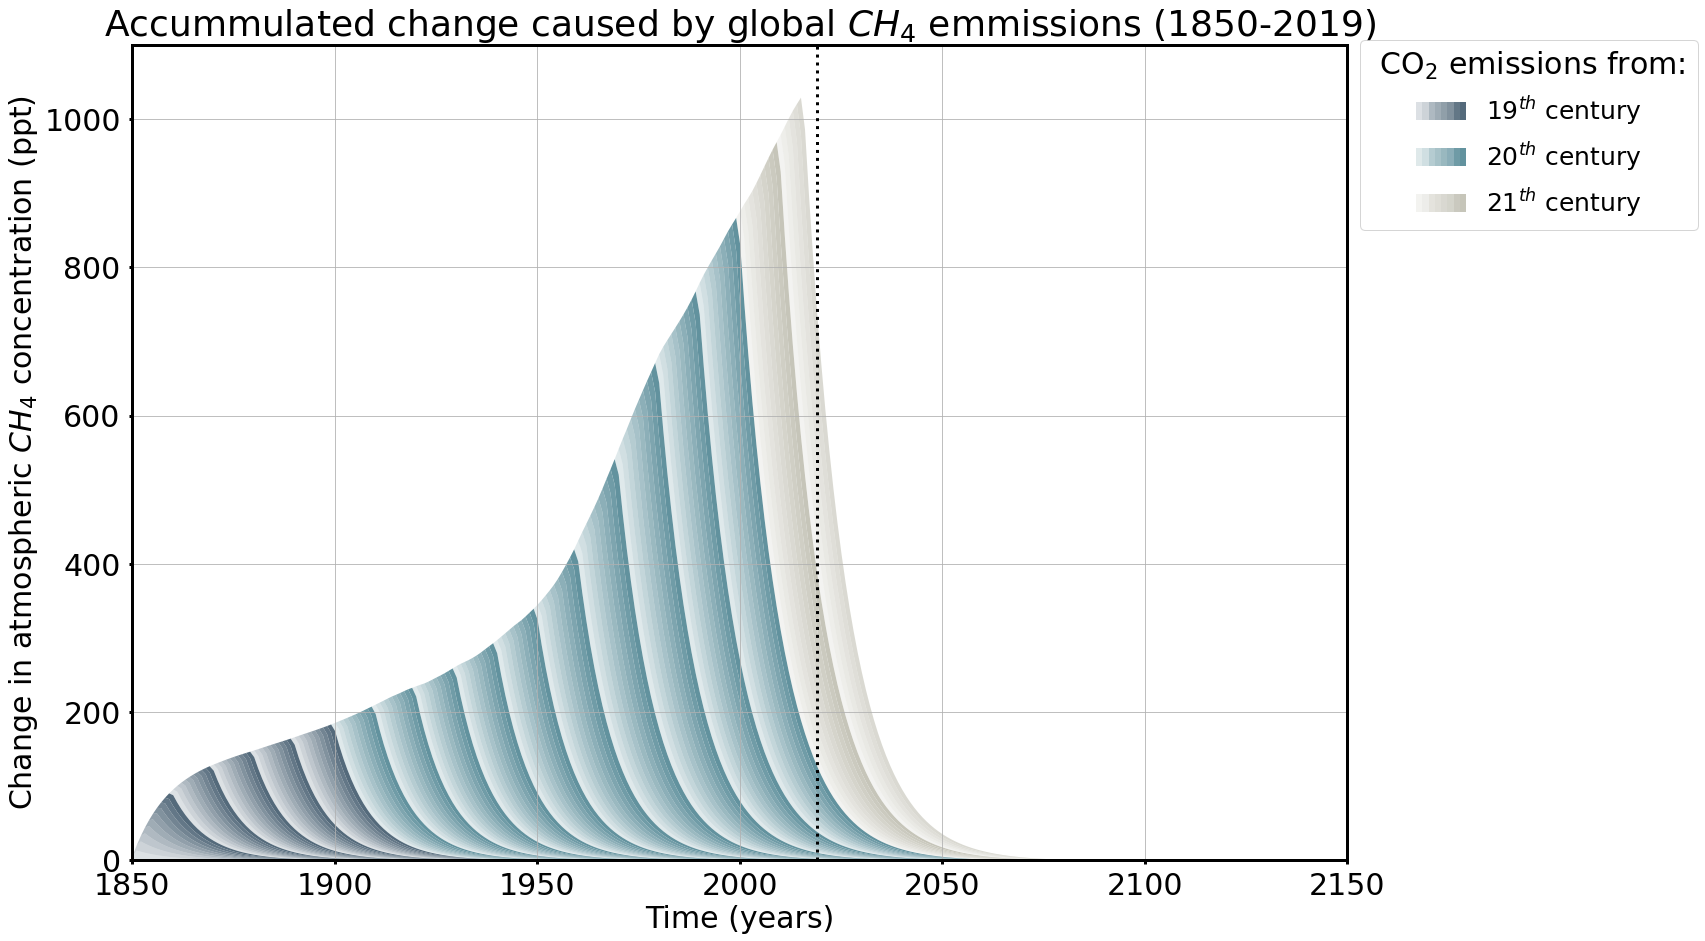

In [13]:
fig = plt.figure(figsize=(25, 15))
grid = plt.GridSpec(1, 1, hspace=0.2, wspace=0, right=0.8)
ax1 = plt.subplot(grid[0])

ch4_diff.loc[:2100,:].plot.area(legend=False, linewidth=0,ax=ax1,cmap=conc_cmap)

ax1.grid()

ax1.axvline(2019,linestyle=':',c='k')
ax1.set_xlim(1850,2150)

ax1.set_ylim(0,1100)

ax1.set_xlabel(None)

ax1.set_ylabel(r'Change in atmospheric $CH_4$ concentration (ppt)')
ax1.set_xlabel('Time (years)', ha='center')

ax1.set_title(r'Accummulated change caused by global $CH_4$ emmissions (1850-2019)')

# legend
cmap_labels = [r'19$^{th}$ century', r'20$^{th}$ century', r'21$^{th}$ century']
cmaps=[color_to_cmap("546A7B"),color_to_cmap("62929E"),color_to_cmap("C6C5B9")]
# create proxy artists as handles:
cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,  loc='center left',bbox_to_anchor=(1, 0.89),
           fontsize=25, title= r' CO$_2$ emissions from: ')
plt.savefig(os.path.join('../plots','conc_CH4_global.png'))

In [14]:
T_diff = (pulse_out['T']-control_out['T']).droplevel(1,axis=1)
# select only values where CH4 from pulse is left in atmosphere
T_diff = T_diff[ch4_diff>0.5]

In [15]:
# save results data
T_diff.loc[1850:2100].to_csv('../data/results/dT_CH4_2100.csv')
ch4_diff.loc[1850:2100].to_csv('../data/results/conc_CH4_2100.csv')

In [16]:
T_diff.loc[1850:2100]

Scenario,yr_1850,yr_1851,yr_1852,yr_1853,yr_1854,yr_1855,yr_1856,yr_1857,yr_1858,yr_1859,...,yr_2010,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,yr_2016,yr_2017,yr_2018,yr_2019
Year,,,,,,,,,,,,,,,,,,,,,
1850,0.000383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1851,0.001280,0.000384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1852,0.001970,0.001283,0.000386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1853,0.002200,0.001975,0.001291,0.000388,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854,0.002257,0.002205,0.001987,0.001296,0.000392,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


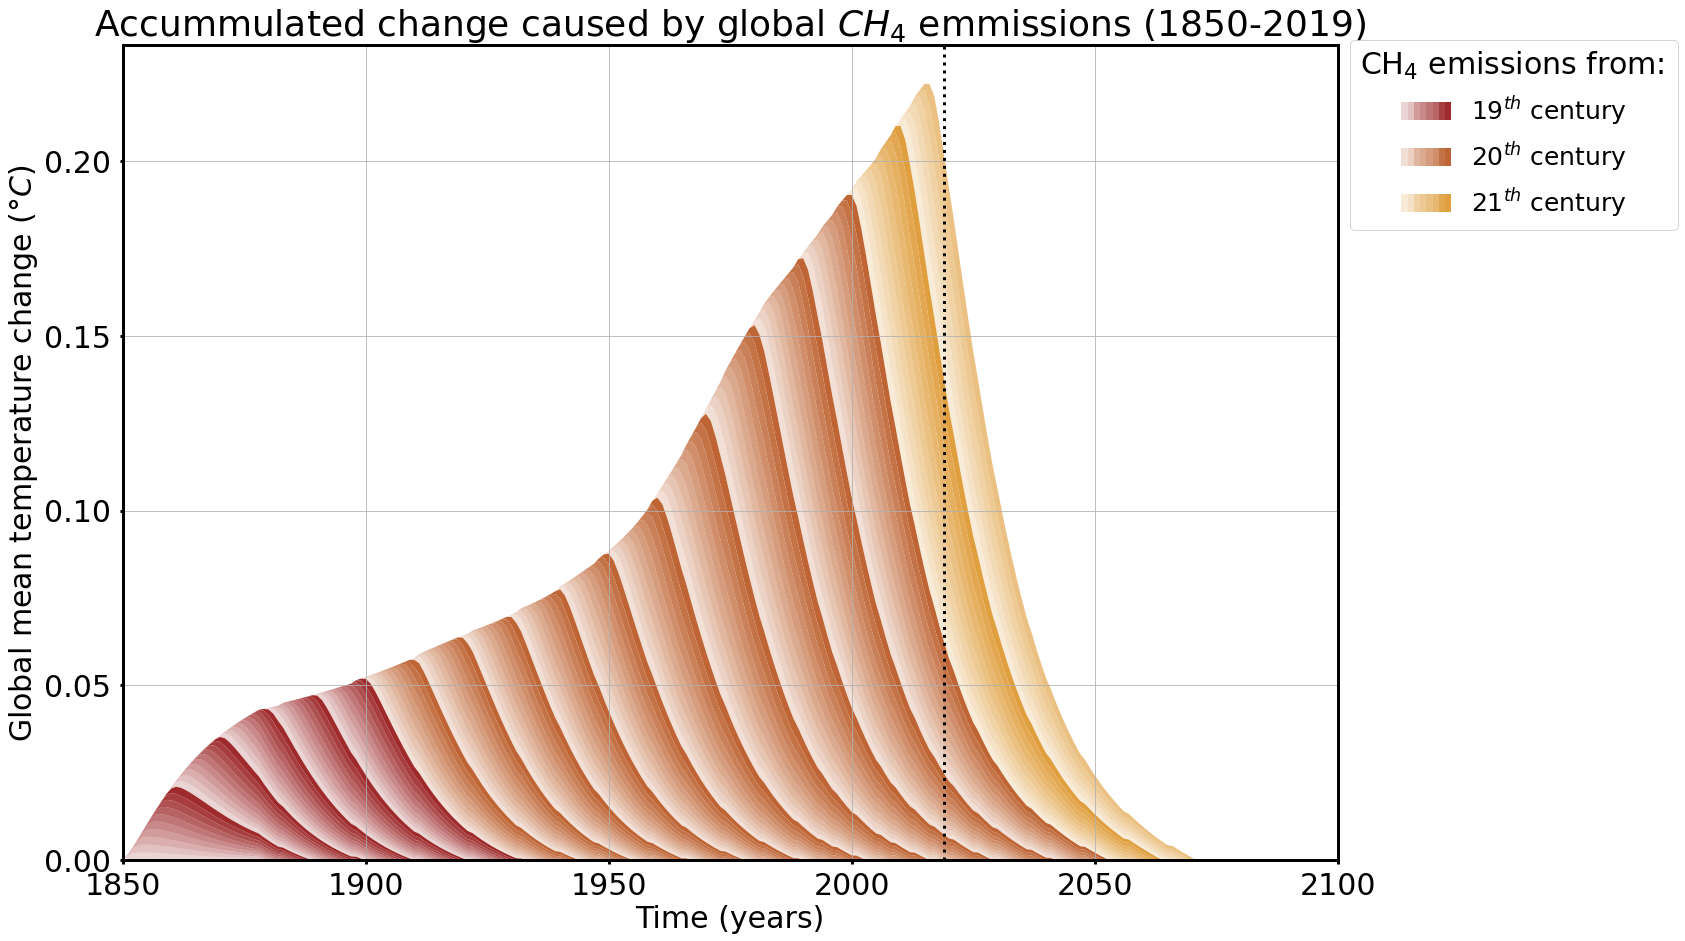

In [17]:
fig = plt.figure(figsize=(25, 15))
grid = plt.GridSpec(1, 1, hspace=0.2, wspace=0, right=0.8)
ax1 = plt.subplot(grid[0])

T_diff.plot.area(legend=False, linewidth=0,ax=ax1,cmap=T_cmap)

ax1.grid()
ax1.set_xlim(1850,2100)

ax1.axvline(2019,linestyle=':',c='k')

ax1.set_ylabel(r'Global mean temperature change ($\degree C$)')
ax1.set_xlabel('Time (years)', ha='center')

ax1.set_title(r'Accummulated change caused by global $CH_4$ emmissions (1850-2019)')

# legend
cmap_labels = [r'19$^{th}$ century', r'20$^{th}$ century', r'21$^{th}$ century']
cmaps=[color_to_cmap("9E2A2B"),color_to_cmap("BF6535"),color_to_cmap("E09F3E")]
# create proxy artists as handles:
cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
legend1 = ax1.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,  loc='center left',bbox_to_anchor=(1, 0.89),
           fontsize=25, title= r'CH$_4$ emissions from: ')
p1 = Line2D([0], [0], color='r', lw=2)
p2 = mpatches.Patch(color='r', alpha=0.2, linewidth=0)
plt.savefig(os.path.join('../plots','dT_CH4_global.png'))